#Preparação do notebook

In [1]:
!pip install geopy
!pip install folium
!pip install meteostat
!pip install dask
!pip install plotly
!pip install plotly dask
!pip install dask[dataframe]
!pip install datashader
!pip install tensorflow jax jaxlib

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 5

In [4]:
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from folium.plugins import HeatMap
from IPython.display import IFrame
import dask.dataframe as dd
from geopy.geocoders import OpenCage
from meteostat import Point, Daily
from datetime import datetime, timedelta
from collections import defaultdict
from dask import delayed, compute
import plotly.graph_objects as go
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import viridis
from sklearn.cluster import DBSCAN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importação dos dados

In [6]:
consumo_parquet_df_path = '/content/drive/Shareddrives/AEGEA/DADOS/CONSUMO_TOTAL_V1_TESTE_DASK.parquet'

In [7]:
consumo_parquet_df = dd.read_parquet(consumo_parquet_df_path, delimiter=';', assume_missing=True)
consumo_parquet_df
num_linhas = consumo_parquet_df.shape[0].compute()
print(f"O dataframe possui {num_linhas} linhas.")

O dataframe possui 24791772 linhas.


In [8]:
pd.set_option('display.max_columns', None)

Tabela de **consumo total** durante os anos de 2019 e 2024

In [9]:
consumo_parquet_df.head(3)

,REFERENCIA,MATRICULA,SEQ_RESPONSAVEL,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,EXCECAO,COD_LATITUDE,COD_LONGITUDE,ANOMES,ANOOS,FRAUDE
0,2021-06-01,17233802,813089.0,30.0,14.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.474361,-54.552343,06/21,<NA>,0
1,2021-02-01,17245048,1001398.0,30.0,12.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.528353,-54.610628,02/21,<NA>,0
2,2021-05-01,17089519,887454.0,30.0,4.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.457875,-54.606836,05/21,<NA>,0


#Análise exploratória


Chave única criada quando unificamos as tabelas de consumo e de fraudes. A chave única é a concatenação do número de 'MATRICULA' e 'SEQ_RESPONSAVEL'

In [10]:
consumo_parquet_df['Chave_unica'] = consumo_parquet_df['MATRICULA'].astype(str) + '_' + consumo_parquet_df['SEQ_RESPONSAVEL'].astype(str)

In [ ]:
consumo_parquet_df.compute()

,REFERENCIA,MATRICULA,SEQ_RESPONSAVEL,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,EXCECAO,COD_LATITUDE,COD_LONGITUDE,ANOMES,ANOOS,FRAUDE,Chave_unica
0,2021-06-01,17233802,813089.0,30.0,14.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.474361,-54.552343,06/21,<NA>,0,17233802_813089.0
1,2021-02-01,17245048,1001398.0,30.0,12.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.528353,-54.610628,02/21,<NA>,0,17245048_1001398.0
2,2021-05-01,17089519,887454.0,30.0,4.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.457875,-54.606836,05/21,<NA>,0,17089519_887454.0
3,2021-10-01,17090232,966567.0,32.0,11.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.453813,-54.595881,10/21,<NA>,0,17090232_966567.0
4,2021-05-01,17835648,1122183.0,31.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.460413,-54.614495,05/21,<NA>,0,17835648_1122183.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4957273,2021-02-01,17582391,1039300.0,29.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,10.0,10.0,MEDIA,Normal,-20.516003,-54.668869,02/21,<NA>,0,17582391_1039300.0
4957274,2021-03-01,1736441,177835.0,30.0,0.0,Hidrometrado,RESIDENCIAL,RES. SOCIAL,10.0,10.0,MEDIA,Normal,-20.491239,-54.631760,03/21,<NA>,0,1736441_177835.0
4957275,2021-02-01,1782928,334340.0,29.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,10.0,10.0,MEDIA,Normal,-20.464472,-54.521082,02/21,<NA>,0,1782928_334340.0
4957276,2021-02-01,17730829,1065042.0,29.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,10.0,10.0,MEDIA,Normal,-20.528720,-54.636929,02/21,<NA>,0,17730829_1065042.0


In [12]:
df_cons_fraude = consumo_parquet_df[['CONS_MEDIDO', 'FRAUDE']].compute()

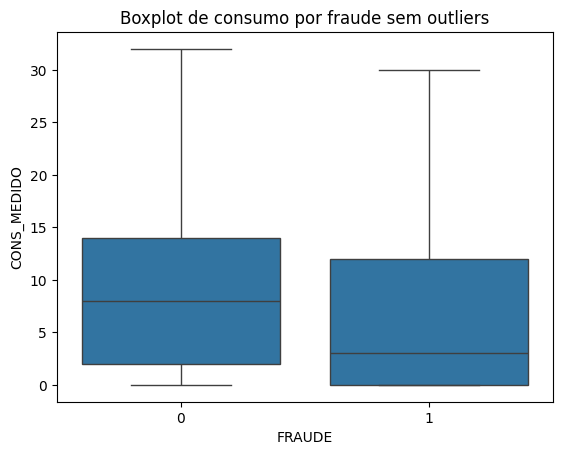

In [15]:
plt.figure()
sns.boxplot(x='FRAUDE', y='CONS_MEDIDO', data=df_cons_fraude, showfliers=False)
plt.title('Boxplot de consumo por fraude sem outliers')
plt.show()

Como podemos observar através desse boxplot, o consumo de água é muito menor perante os clientes que realizaram alguma fraude. A diferença é observável principalmente pela mediana de consumo dos fraudadores ser quase 2x menor.Também apresentam os casos de fraude uma variabilidade de consumo ligeiramente menor.

In [12]:
df = consumo_parquet_df.compute()
df

,REFERENCIA,MATRICULA,SEQ_RESPONSAVEL,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,EXCECAO,COD_LATITUDE,COD_LONGITUDE,ANOMES,ANOOS,FRAUDE,Chave_unica
0,2021-06-01,17233802,813089.0,30.0,14.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.474361,-54.552343,06/21,<NA>,0,17233802_813089.0
1,2021-02-01,17245048,1001398.0,30.0,12.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.528353,-54.610628,02/21,<NA>,0,17245048_1001398.0
2,2021-05-01,17089519,887454.0,30.0,4.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.457875,-54.606836,05/21,<NA>,0,17089519_887454.0
3,2021-10-01,17090232,966567.0,32.0,11.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.453813,-54.595881,10/21,<NA>,0,17090232_966567.0
4,2021-05-01,17835648,1122183.0,31.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.460413,-54.614495,05/21,<NA>,0,17835648_1122183.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4957273,2021-02-01,17582391,1039300.0,29.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,10.0,10.0,MEDIA,Normal,-20.516003,-54.668869,02/21,<NA>,0,17582391_1039300.0
4957274,2021-03-01,1736441,177835.0,30.0,0.0,Hidrometrado,RESIDENCIAL,RES. SOCIAL,10.0,10.0,MEDIA,Normal,-20.491239,-54.631760,03/21,<NA>,0,1736441_177835.0
4957275,2021-02-01,1782928,334340.0,29.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,10.0,10.0,MEDIA,Normal,-20.464472,-54.521082,02/21,<NA>,0,1782928_334340.0
4957276,2021-02-01,17730829,1065042.0,29.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,10.0,10.0,MEDIA,Normal,-20.528720,-54.636929,02/21,<NA>,0,17730829_1065042.0


In [23]:
df.query('FRAUDE == 0')

,REFERENCIA,MATRICULA,SEQ_RESPONSAVEL,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,EXCECAO,COD_LATITUDE,COD_LONGITUDE,ANOMES,ANOOS,FRAUDE,Chave_unica
0,2021-06-01,17233802,813089.0,30.0,14.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.474361,-54.552343,06/21,<NA>,0,17233802_813089.0
1,2021-02-01,17245048,1001398.0,30.0,12.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.528353,-54.610628,02/21,<NA>,0,17245048_1001398.0
2,2021-05-01,17089519,887454.0,30.0,4.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.457875,-54.606836,05/21,<NA>,0,17089519_887454.0
3,2021-10-01,17090232,966567.0,32.0,11.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.453813,-54.595881,10/21,<NA>,0,17090232_966567.0
4,2021-05-01,17835648,1122183.0,31.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.460413,-54.614495,05/21,<NA>,0,17835648_1122183.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4957273,2021-02-01,17582391,1039300.0,29.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,10.0,10.0,MEDIA,Normal,-20.516003,-54.668869,02/21,<NA>,0,17582391_1039300.0
4957274,2021-03-01,1736441,177835.0,30.0,0.0,Hidrometrado,RESIDENCIAL,RES. SOCIAL,10.0,10.0,MEDIA,Normal,-20.491239,-54.631760,03/21,<NA>,0,1736441_177835.0
4957275,2021-02-01,1782928,334340.0,29.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,10.0,10.0,MEDIA,Normal,-20.464472,-54.521082,02/21,<NA>,0,1782928_334340.0
4957276,2021-02-01,17730829,1065042.0,29.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,10.0,10.0,MEDIA,Normal,-20.528720,-54.636929,02/21,<NA>,0,17730829_1065042.0


### Padrão de consumo de um fraudador

In [26]:
matricula_cor = df.query('MATRICULA == "17543161"').sort_values(by='REFERENCIA', ascending=True)
fig = px.line(matricula_cor, x="REFERENCIA", y="CONS_MEDIDO", title='Padrão consumo de um fraudador')
fig.show()

### Padrão de um consumo de um não fraudador

In [27]:
matricula_cor = df.query('MATRICULA == "17245048"').sort_values(by='REFERENCIA', ascending=True)
fig = px.line(matricula_cor, x="REFERENCIA", y="CONS_MEDIDO", title='Padrão consumo de um NÃO fraudador')
fig.show()

<Axes: xlabel='FRAUDE'>

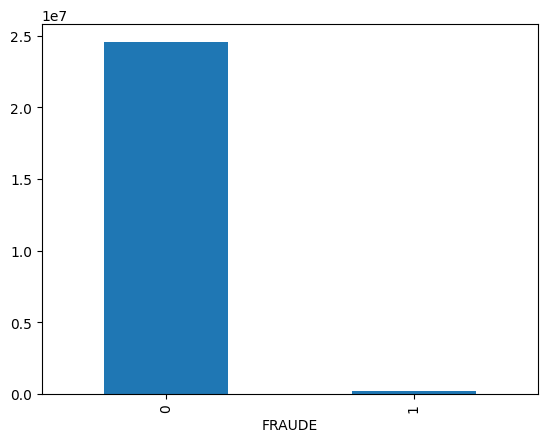

In [28]:
df['FRAUDE'].value_counts().plot(kind='bar')

## Análise de geolocalização

Criamos alguns gráficos que achamos que podem ser interessantes e ajudar a gerar insights e identificar padrões relacionados as fraudes. Devido ao grande volume de dados, usamos o método de clusterização para juntar pontos próximos e sermos capazes de processar um volume maior de dados

1. Gráfico de densidade de MATRICULA

Esse gráfico mostra quais regiões possuem mais matrículas. Esse gráfico pode ser interessante para analisarmos quais áreas da cidade tem o maior número de consumidores de água.

In [ ]:
dados_com_coordenadas = consumo_parquet_df[['COD_LATITUDE', 'COD_LONGITUDE']].dropna()
dados_amostra = dados_com_coordenadas.head(1000)

fig = px.density_mapbox(dados_amostra,
                       lat='COD_LATITUDE',
                       lon='COD_LONGITUDE',
                       radius=10,
                       center=dict(lat=dados_amostra['COD_LATITUDE'].mean(),
                                   lon=dados_amostra['COD_LONGITUDE'].mean()),
                       zoom=10,
                       mapbox_style="open-street-map")

fig.show()

2. Gráfico de consumo de água

Esse gráfico mostra o consumo de água mensal dessa região em metros cúbicos (1000 L). Ele pode ser muito interessante para determinar se o consumo de alguma região mudou muito drasticamente de um mês para o outro e quais regiões tendem a consumir mais ou menos água.

In [ ]:
dados_com_coordenadas = consumo_parquet_df[['COD_LATITUDE', 'COD_LONGITUDE', 'CONS_MEDIDO']].dropna()

dados_amostra = dados_com_coordenadas.head(10000)

db = DBSCAN(eps=0.01, min_samples=10).fit(dados_amostra[['COD_LATITUDE', 'COD_LONGITUDE']])
dados_amostra['cluster'] = db.labels_

dados_filtrados = dados_amostra[dados_amostra['cluster'] != -1]

fig = px.density_mapbox(dados_filtrados,
                        lat='COD_LATITUDE',
                        lon='COD_LONGITUDE',
                        z='CONS_MEDIDO',
                        radius=10,
                        center=dict(lat=dados_filtrados['COD_LATITUDE'].mean(),
                                    lon=dados_filtrados['COD_LONGITUDE'].mean()),
                        zoom=10,
                        mapbox_style="open-street-map",
                        color_continuous_scale="Viridis")

fig.show()

3. Gráfico de fraudes

Esse gráfico mostra o número de matrículas fraudulentas e não fraudulentas. Os pontos vermelhos simbolizam matrículas que já fraudaram em algum momento, e os pontos azuis matrículas que nunca fraudaram. A ideia desse gráfico era procurar áreas onde o número de fraudes é maior do que o normal, oque poderia nos ajudar a identificar padrões.

In [ ]:
dados_com_fraude = consumo_parquet_df[['COD_LATITUDE', 'COD_LONGITUDE', 'FRAUDE']].dropna()

amostra_inicial = dados_com_fraude.head(10000)

# Usar DBSCAN para agrupar pontos próximos
db = DBSCAN(eps=0.01, min_samples=10).fit(amostra_inicial[['COD_LATITUDE', 'COD_LONGITUDE']])
amostra_inicial['cluster'] = db.labels_

# Filtrar ruídos (-1) ou clusters pequenos, se necessário
dados_filtrados = amostra_inicial[amostra_inicial['cluster'] != -1]

# Criar uma coluna 'COR' para mapear 0 para azul e 1 para vermelho
dados_filtrados['COR'] = dados_filtrados['FRAUDE'].map({0: 'blue', 1: 'red'})

# Criar o gráfico de mapa de calor, ajustando a cor pela coluna 'COR'
fig = px.scatter_mapbox(dados_filtrados,
                        lat='COD_LATITUDE',
                        lon='COD_LONGITUDE',
                        color='COR',
                        size_max=15,
                        color_discrete_map={"blue": "blue", "red": "red"},
                        center=dict(lat=dados_filtrados['COD_LATITUDE'].mean(),
                                    lon=dados_filtrados['COD_LONGITUDE'].mean()),
                        zoom=10,  # Ajuste o zoom conforme necessário
                        mapbox_style="open-street-map")

# Garantir que as cores azul e vermelho estejam na legenda mesmo se uma estiver ausente
fig.update_layout(coloraxis_colorbar=dict(title="Fraude",
                                          tickvals=[0, 1],
                                          ticktext=['Sem Fraude', 'Fraude']))

# Exibir o gráfico
fig.show()

<ipython-input-11-8b6db01a8944>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4. Gráfico de fraudes e consumo de água

Esse gráfico mostra as matrículas fraudulentas com relação ao consumo de água por região. O intuito desse gráfico era estudar se há alguma relação entre o consumo de água de uma matrícula e se a matrícula já fraudou em algum momento. A nossa teoria era que se o consumo mensal de uma matrícula fosse muito menor do que a média da região, então as chances de ter ocorrido uma fraude seria maior.

In [ ]:
dados_com_coordenadas = consumo_parquet_df[['COD_LATITUDE', 'COD_LONGITUDE', 'CONS_MEDIDO', 'FRAUDE']].dropna()

amostra_inicial = dados_com_coordenadas.head(10000)

# Usar DBSCAN para agrupar pontos próximos
db = DBSCAN(eps=0.01, min_samples=10).fit(amostra_inicial[['COD_LATITUDE', 'COD_LONGITUDE']])
amostra_inicial['cluster'] = db.labels_

# Filtrar ruídos (-1) ou clusters pequenos, se necessário
dados_filtrados = amostra_inicial[amostra_inicial['cluster'] != -1]

# Criar o gráfico de mapa de calor com 'CONS_MEDIDO'
fig = px.density_mapbox(dados_filtrados,
                        lat='COD_LATITUDE',
                        lon='COD_LONGITUDE',
                        z='CONS_MEDIDO',  # Ajustando a intensidade pela coluna 'CONS_MEDIDO'
                        radius=10,
                        center=dict(lat=dados_filtrados['COD_LATITUDE'].mean(),
                                    lon=dados_filtrados['COD_LONGITUDE'].mean()),
                        zoom=10,  # Ajuste o zoom conforme necessário
                        mapbox_style="open-street-map",
                        color_continuous_scale="Viridis")  # Ajuste o esquema de cores conforme necessário

# Adicionar os pontos vermelhos para indicar fraudes
dados_fraude = dados_filtrados[dados_filtrados['FRAUDE'] == 1]
fig.add_trace(go.Scattermapbox(
    lat=dados_fraude['COD_LATITUDE'],
    lon=dados_fraude['COD_LONGITUDE'],
    mode='markers',
    marker=go.scattermapbox.Marker(size=9, color='red'),
    name='Fraude'
))

# Exibir o gráfico
fig.show()

# Features

## ETL

1. Chave única

Quando nós recebemos os dados, recebemos duas tabelas, uma de fraudes, que indicava matrículas que já fraudaram e quando fraudaram, e uma de consumo geral, que indicava o consumo das matrículas, sem indicação de fraudes. Como ambas as tabelas possuíam dados muito importantes, resolvemos inificá-las em um único dataframe. Para isso, tivemos que criar uma chave especíica para cada matrícula que foi cruzada. Essa chave única é criada a partir da concatenação do valor de 'MATRICULA' e de 'SEQ_RESPONSAVEL', gerando um valor totalmente único e irreplicável. Isso acontece uma vez que uma matrícula pode ter mais de um contrato vinculado, referente ao 'SEQ_RESPONSAVEL'.

In [ ]:
consumo_parquet_df['Chave_unica'] = consumo_parquet_df['MATRICULA'].astype(str) + '_' + consumo_parquet_df['SEQ_RESPONSAVEL'].astype(str)

2. Fraude

Criamos também uma coluna de feature binária referente a fraude. Essa coluna será essencial para o treinamento do modelo, uma vez que garantirá que o modelo está verídico.

3. Temperatura

Aqui criamos uma coluna de feature referente a temperatura. Essa temperatura é encontrada usando uma biblioteca de metereologia, passando os valores de latitude e longitude e calculando a média da temperatura dos últimos 30 dias, que é o tempo qntre uma medição e outra.

In [ ]:
import pandas as pd
from meteostat import Point, Daily
from datetime import timedelta
from functools import lru_cache

# Função para obter temperatura com cache
@lru_cache(maxsize=None)
def obter_temperatura_cache(latitude, longitude, data_final):
    data_inicial = data_final - timedelta(days=30)  # Um mês antes

    # Chamada à API Meteostat
    location = Point(latitude, longitude)
    data = Daily(location, data_inicial, data_final)
    data = data.fetch()

    # Retorna a temperatura média ou None se não houver dados
    if not data.empty:
        return data['tavg'].mean()
    else:
        return None

# Função para aplicar a temperatura em lote
def aplicar_temperatura_em_lote(df):
    # Extrair dados únicos para a cache
    unique_coords = df[['COD_LATITUDE', 'COD_LONGITUDE', 'ANOMES']].drop_duplicates()

    # Criar uma coluna para armazenar temperaturas
    unique_coords['Temperatura'] = unique_coords.apply(
        lambda row: obter_temperatura_cache(row['COD_LATITUDE'], row['COD_LONGITUDE'], row['ANOMES']),
        axis=1
    )

    # Criar um dicionário de mapeamento de temperaturas
    temp_dict = unique_coords.set_index(['COD_LATITUDE', 'COD_LONGITUDE', 'ANOMES'])['Temperatura'].to_dict()

    # Mapear temperaturas de volta para o DataFrame original
    df['Temperatura'] = df.apply(
        lambda row: temp_dict.get((row['COD_LATITUDE'], row['COD_LONGITUDE'], row['ANOMES'])),
        axis=1
    )
    return df

# Selecionar uma amostra das primeiras 1000 linhas
consumo_medido_amostra = consumo_parquet_df.head(100000)

# Conversão da coluna 'ANOMES' para datetime
consumo_medido_amostra['ANOMES'] = pd.to_datetime(consumo_medido_amostra['ANOMES'], format='%m/%y')

# Aplicar a função de temperatura em lote à amostra
consumo_medido_amostra = aplicar_temperatura_em_lote(consumo_medido_amostra)

# Mostrar as primeiras linhas para verificar
consumo_medido_amostra.head()

,REFERENCIA,MATRICULA,SEQ_RESPONSAVEL,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,EXCECAO,COD_LATITUDE,COD_LONGITUDE,ANOMES,ANOOS,FRAUDE,Chave_unica,Temperatura
0,2021-06-01,17233802,813089.0,30.0,14.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,None,Normal,-20.474361,-54.552343,2021-06-01,None,0,17233802_813089.0,22.438710
1,2021-02-01,17245048,1001398.0,30.0,12.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,None,Normal,-20.528353,-54.610628,2021-02-01,None,0,17245048_1001398.0,24.412903
2,2021-05-01,17089519,887454.0,30.0,4.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,None,Normal,-20.457875,-54.606836,2021-05-01,None,0,17089519_887454.0,24.164516
3,2021-10-01,17090232,966567.0,32.0,11.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,None,Normal,-20.453813,-54.595881,2021-10-01,None,0,17090232_966567.0,27.545161
4,2021-05-01,17835648,1122183.0,31.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,None,Normal,-20.460413,-54.614495,2021-05-01,None,0,17835648_1122183.0,24.164516


4. Endereço

De forma similar, usamos as coluans de latitude e longitude para encontrar o endereço exato de cada uma das matrículas com uma biblioteca de geolocalização. Com isso, criamos três colunas de features que pensamos que seriam muito relevantes para o modelo: Rua, Bairro e Estado.

In [ ]:
geolocator = Nominatim(user_agent="geocoding_script")

# Função para obter o endereço
@delayed
def obter_endereco(latitude, longitude):
    try:
        location = geolocator.reverse((latitude, longitude), language='pt')
        if location:
            address = location.raw['address']
            rua = address.get('road', None)
            bairro = address.get('suburb', None)
            estado = address.get('state', None)
            return (rua, bairro, estado)
        else:
            return (None, None, None)
    except Exception:
        return (None, None, None)

# Função para processar o DataFrame
def processar_pequena_parte(df):
    enderecos = df.apply(lambda row: obter_endereco(row['COD_LATITUDE'], row['COD_LONGITUDE']), axis=1)
    enderecos_computados = compute(*enderecos)
    df[['Rua', 'Bairro', 'Estado']] = pd.DataFrame(enderecos_computados, index=df.index)
    return df

# Processar a pequena parte do DataFrame
resultado_final = processar_pequena_parte(consumo_medido_amostra)

# Verificar as primeiras linhas do resultado final
resultado_final.head()

Streaming output truncated to the last 5000 lines.


,REFERENCIA,MATRICULA,SEQ_RESPONSAVEL,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,EXCECAO,COD_LATITUDE,COD_LONGITUDE,ANOMES,ANOOS,FRAUDE,Chave_unica,Temperatura,Rua,Bairro,Estado
0,2021-06-01,17233802,813089.0,30.0,14.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,None,Normal,-20.474361,-54.552343,2021-06-01,None,0,17233802_813089.0,22.438710,None,None,None
1,2021-02-01,17245048,1001398.0,30.0,12.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,None,Normal,-20.528353,-54.610628,2021-02-01,None,0,17245048_1001398.0,24.412903,None,None,None
2,2021-05-01,17089519,887454.0,30.0,4.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,None,Normal,-20.457875,-54.606836,2021-05-01,None,0,17089519_887454.0,24.164516,None,None,None
3,2021-10-01,17090232,966567.0,32.0,11.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,None,Normal,-20.453813,-54.595881,2021-10-01,None,0,17090232_966567.0,27.545161,None,None,None
4,2021-05-01,17835648,1122183.0,31.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,None,Normal,-20.460413,-54.614495,2021-05-01,None,0,17835648_1122183.0,24.164516,None,None,None


In [ ]:
# Imprimir os nomes das colunas
print(resultado_final.columns)

# Imprimir os primeiros 3 valores do DataFrame
print(resultado_final.head(3))

Index(['REFERENCIA', 'MATRICULA', 'SEQ_RESPONSAVEL', 'DIAS_LEITURA',
       'CONS_MEDIDO', 'TIPO_LIGACAO', 'CATEGORIA', 'SUB_CATEGORIA',
       'VOLUME_ESTIMADO', 'VOLUME_ESTIMADO_ACUM', 'FATURADO_MEDIA', 'EXCECAO',
       'COD_LATITUDE', 'COD_LONGITUDE', 'ANOMES', 'ANOOS', 'FRAUDE',
       'Chave_unica', 'Temperatura', 'Rua', 'Bairro', 'Estado'],
      dtype='object')
  REFERENCIA MATRICULA  SEQ_RESPONSAVEL  DIAS_LEITURA  CONS_MEDIDO  \
0 2021-06-01  17233802         813089.0          30.0         14.0   
1 2021-02-01  17245048        1001398.0          30.0         12.0   
2 2021-05-01  17089519         887454.0          30.0          4.0   

   TIPO_LIGACAO    CATEGORIA SUB_CATEGORIA  VOLUME_ESTIMADO  \
0  Hidrometrado  RESIDENCIAL   RESIDENCIAL              0.0   
1  Hidrometrado  RESIDENCIAL   RESIDENCIAL              0.0   
2  Hidrometrado    COMERCIAL     COMERCIAL              0.0   

   VOLUME_ESTIMADO_ACUM FATURADO_MEDIA EXCECAO  COD_LATITUDE  COD_LONGITUDE  \
0              

In [ ]:
# Apagar as colunas 'FATURADO_MEDIA' e 'ANOOS'
resultado_final = resultado_final.drop(columns=['FATURADO_MEDIA', 'ANOOS'])

# Verificando as colunas restantes após a exclusão
print(resultado_final.columns)

Index(['REFERENCIA', 'MATRICULA', 'SEQ_RESPONSAVEL', 'DIAS_LEITURA',
       'CONS_MEDIDO', 'TIPO_LIGACAO', 'CATEGORIA', 'SUB_CATEGORIA',
       'VOLUME_ESTIMADO', 'VOLUME_ESTIMADO_ACUM', 'EXCECAO', 'COD_LATITUDE',
       'COD_LONGITUDE', 'ANOMES', 'FRAUDE', 'Chave_unica', 'Temperatura',
       'Rua', 'Bairro', 'Estado'],
      dtype='object')


In [ ]:
resultado_final.head()

,REFERENCIA,MATRICULA,SEQ_RESPONSAVEL,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,EXCECAO,COD_LATITUDE,COD_LONGITUDE,ANOMES,FRAUDE,Chave_unica,Temperatura,Rua,Bairro,Estado
0,2021-06-01,17233802,813089.0,30.0,14.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,Normal,-20.474361,-54.552343,2021-06-01,0,17233802_813089.0,22.438710,None,None,None
1,2021-02-01,17245048,1001398.0,30.0,12.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,Normal,-20.528353,-54.610628,2021-02-01,0,17245048_1001398.0,24.412903,None,None,None
2,2021-05-01,17089519,887454.0,30.0,4.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,Normal,-20.457875,-54.606836,2021-05-01,0,17089519_887454.0,24.164516,None,None,None
3,2021-10-01,17090232,966567.0,32.0,11.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,Normal,-20.453813,-54.595881,2021-10-01,0,17090232_966567.0,27.545161,None,None,None
4,2021-05-01,17835648,1122183.0,31.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,Normal,-20.460413,-54.614495,2021-05-01,0,17835648_1122183.0,24.164516,None,None,None


In [ ]:
# Printar os valores únicos de cada coluna especificada
print("Valores únicos da coluna 'TIPO_LIGACAO':")
print(resultado_final['TIPO_LIGACAO'].unique())

print("\nValores únicos da coluna 'CATEGORIA':")
print(resultado_final['CATEGORIA'].unique())

print("\nValores únicos da coluna 'SUB_CATEGORIA':")
print(resultado_final['SUB_CATEGORIA'].unique())

print("\nValores únicos da coluna 'Rua':")
print(resultado_final['Rua'].unique())

print("\nValores únicos da coluna 'Bairro':")
print(resultado_final['Bairro'].unique())

print("\nValores únicos da coluna 'Estado':")
print(resultado_final['Estado'].unique())

print("\nValores únicos da coluna 'EXCECAO':")
print(resultado_final['EXCECAO'].unique())

Valores únicos da coluna 'TIPO_LIGACAO':
['Hidrometrado' 'Consumo Fixo']

Valores únicos da coluna 'CATEGORIA':
['RESIDENCIAL' 'COMERCIAL' 'PUBLICA' 'INDUSTRIAL']

Valores únicos da coluna 'SUB_CATEGORIA':
['RESIDENCIAL' 'COMERCIAL' 'PUB. MUNICIPAL' 'PUBLICA' 'RES. SOCIAL'
 'INDUSTRIAL']

Valores únicos da coluna 'Rua':
[None 'Rua das Olimpíadas' 'Avenida Zacarias de Paula Nantes' ...
 'Rua Oswaldo Goeldi' 'Rua Cumbaru' 'Avenida João Rosa Pires']

Valores únicos da coluna 'Bairro':
[None 'União' 'Jockey Club' 'Bandeirantes' 'Caiçara' 'Carlota'
 'Santo Amaro' 'Coronel Antonino' 'Sobrinho' 'Rita Vieira' 'Guanandi'
 'Tijuca' 'Caiobá' 'São Bento' 'Cruzeiro' 'Tarumã' 'Alves Pereira'
 'Coophafé' 'Centro Oeste' 'Monte Castelo' 'Mata do Segredo' 'Centro'
 'Pioneiros' 'Nova Lima' 'Leblon' 'Universitário' 'Santo Antônio'
 'Itanhangá' 'Centenário' 'Nasser' 'Novos Estados' 'Mata do Jacinto'
 'Popular' 'Vila Carvalho' 'Aero Rancho' 'Maria Aparecida Pedrossian'
 'Tiradentes' 'Piratininga' 'Jacy' 'Au

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df_final_tratado = resultado_final.copy()

# Supondo que 'df_final_tratado' já esteja carregado
# Define as colunas categóricas que você deseja codificar
categorical_columns = ['CATEGORIA', 'TIPO_LIGACAO', 'SUB_CATEGORIA']

# Cria um dicionário para armazenar os LabelEncoders
label_encoders = {}

# Aplica o Label Encoding nas colunas categóricas
for column in categorical_columns:
    if column in df_final_tratado.columns:
        le = LabelEncoder()
        df_final_tratado[column] = le.fit_transform(df_final_tratado[column])
        label_encoders[column] = le  # Salva o LabelEncoder para possível uso futuro
    else:
        print(f"Coluna '{column}' não encontrada no DataFrame.")

# Exibe o DataFrame resultante
df_final_tratado.head()

,REFERENCIA,MATRICULA,SEQ_RESPONSAVEL,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,EXCECAO,COD_LATITUDE,COD_LONGITUDE,ANOMES,FRAUDE,Chave_unica,Temperatura,Rua,Bairro,Estado
0,2021-06-01,17233802,813089.0,30.0,14.0,1,3,5,0.0,0.0,Normal,-20.474361,-54.552343,2021-06-01,0,17233802_813089.0,22.438710,None,None,None
1,2021-02-01,17245048,1001398.0,30.0,12.0,1,3,5,0.0,0.0,Normal,-20.528353,-54.610628,2021-02-01,0,17245048_1001398.0,24.412903,None,None,None
2,2021-05-01,17089519,887454.0,30.0,4.0,1,0,0,0.0,0.0,Normal,-20.457875,-54.606836,2021-05-01,0,17089519_887454.0,24.164516,None,None,None
3,2021-10-01,17090232,966567.0,32.0,11.0,1,0,0,0.0,0.0,Normal,-20.453813,-54.595881,2021-10-01,0,17090232_966567.0,27.545161,None,None,None
4,2021-05-01,17835648,1122183.0,31.0,0.0,1,0,0,0.0,0.0,Normal,-20.460413,-54.614495,2021-05-01,0,17835648_1122183.0,24.164516,None,None,None


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Verificar as colunas presentes no DataFrame
print("Colunas disponíveis no DataFrame:")
print(df_final_tratado.columns.tolist())

# Listar colunas a serem removidas
cols_to_drop = ['REFERENCIA', 'MATRICULA', 'SEQ_RESPONSAVEL', 'COD_LATITUDE', 'COD_LONGITUDE']

# Remover apenas colunas que realmente existem
cols_to_drop_existing = [col for col in cols_to_drop if col in df_final_tratado.columns]
df_final_tratado = df_final_tratado.drop(columns=cols_to_drop_existing)

# Preencher valores NaN na coluna 'Temperatura' com a média da coluna
if 'Temperatura' in df_final_tratado.columns:
    df_final_tratado['Temperatura'] = df_final_tratado['Temperatura'].fillna(df_final_tratado['Temperatura'].mean())
    df_final_tratado['Temperatura'] = df_final_tratado['Temperatura'].round().astype(int)

# Aplicar Label Encoding à coluna 'Bairro'
if 'Bairro' in df_final_tratado.columns:
    le = LabelEncoder()
    df_final_tratado['Bairro'] = le.fit_transform(df_final_tratado['Bairro'])

# Remover colunas adicionais se existirem
cols_to_drop_additional = ['EXCECAO', 'Chave_unica', 'Rua', 'Estado']
cols_to_drop_additional_existing = [col for col in cols_to_drop_additional if col in df_final_tratado.columns]
df_final_tratado = df_final_tratado.drop(columns=cols_to_drop_additional_existing)

# Verificar o DataFrame resultante
df_final_tratado.head()

Colunas disponíveis no DataFrame:
['REFERENCIA', 'MATRICULA', 'SEQ_RESPONSAVEL', 'DIAS_LEITURA', 'CONS_MEDIDO', 'TIPO_LIGACAO', 'CATEGORIA', 'SUB_CATEGORIA', 'VOLUME_ESTIMADO', 'VOLUME_ESTIMADO_ACUM', 'EXCECAO', 'COD_LATITUDE', 'COD_LONGITUDE', 'ANOMES', 'FRAUDE', 'Chave_unica', 'Temperatura', 'Rua', 'Bairro', 'Estado']


,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,ANOMES,FRAUDE,Temperatura,Bairro
0,30.0,14.0,1,3,5,0.0,0.0,2021-06-01,0,22,86
1,30.0,12.0,1,3,5,0.0,0.0,2021-02-01,0,24,86
2,30.0,4.0,1,0,0,0.0,0.0,2021-05-01,0,24,86
3,32.0,11.0,1,0,0,0.0,0.0,2021-10-01,0,28,86
4,31.0,0.0,1,0,0,0.0,0.0,2021-05-01,0,24,86


In [ ]:
from sklearn.model_selection import train_test_split

# Verificar e converter todas as colunas para tipo numérico, se necessário
df_final_tratado = df_final_tratado.apply(pd.to_numeric, errors='coerce')

# Verificar se há valores nulos e preencher ou remover se necessário
df_final_tratado = df_final_tratado.fillna(df_final_tratado.mean())  # Preencher valores nulos com a média
# Alternativamente, você pode remover linhas com valores nulos:
# df_final_tratado = df_final_tratado.dropna()

# Separar novamente as features e o target após a limpeza
X = df_final_tratado.drop(columns=['FRAUDE'])
y = df_final_tratado['FRAUDE']

# Dividir o DataFrame em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

# Supondo que df_final_tratado já esteja carregado e tratado

# Separar as features e o target
X = df_final_tratado.drop(columns=['FRAUDE'])
y = df_final_tratado['FRAUDE']

# Dividir o DataFrame em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definir o modelo de rede neural
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))  # Usar Input para definir a forma da entrada
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Fazer previsões
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Calcular e imprimir o classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Calcular e imprimir a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9820 - loss: 526466521497600.0000 - val_accuracy: 0.9956 - val_loss: 197868388352000.0000
Epoch 2/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9906 - loss: 320609712078848.0000 - val_accuracy: 0.9956 - val_loss: 421129495773184.0000
Epoch 3/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9894 - loss: 369128179236864.0000 - val_accuracy: 0.9956 - val_loss: 81879743070208.0000
Epoch 4/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9899 - loss: 223534693482496.0000 - val_accuracy: 0.9956 - val_loss: 184834655780864.0000
Epoch 5/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9906 - loss: 160459541970944.0000 - val_accuracy: 0.9956 - val_loss: 10151887110144.0000
Epoch 6/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9892 - loss: 106847428149248.0000 - val_accuracy: 0.9956 - val_loss: 505918029824.0000
Epoch 7/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

